In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [3]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'dmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')
# input_paths.append('/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'amoc'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1_v2/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None
ref_cstr, ref_cnum = 'blue2red', 20
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = None, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995
ref_rescale = None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac, climit = None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol       = 2
which_dpi  = 300
do_contour = True
which_transf = 'dmoc' # 'srf', 'inner', 'dmoc'
do_reffig  = True
do_zcoord  = True #False
# from where provide zinfo for projection to zcoord, options: 'std_dens_H'(Best), 'hydrography'(OK), 
# 'density_dMOC'(Bad), 'std_dens_Z'(Very Bad)
do_useZinfo= 'std_dens_H' 
do_bolus   = True
figfac     = [8, 3.5] #[7, 3.5]

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True)

#______________________________________________________________________________________________________
if (which_cycl != None) and (which_cycl != "None"): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path != None) and (ref_path != "None"): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path != None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
else:
    do_reffig=False    

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path != None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths, ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names    

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:139: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


### ATTENTION:
use here the density MOC levels that are specfic for your run. They might be different from the one im using here since they might need to be customized specific to your hydrography to be able to cover the whole density range in your simulation. So check the code you are using (see. gen_modules_diag.F90)

In [5]:
#______________________________________________________________________________________________________            
# define density levels 
# original dima
# std_dens=[0.0000,   30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
# 32.77778, 33.01000, 33.33333, 33.56000, 33.88889, 34.11000, 34.44444, 34.62000, 35.00000,
# 35.05000, 35.10622, 35.20319, 35.29239, 35.37498, 35.41300, 35.45187, 35.52380, 35.59136,
# 35.65506, 35.71531, 35.77247, 35.82685, 35.87869, 35.92823, 35.97566, 35.98000, 36.02115,
# 36.06487, 36.10692, 36.14746, 36.18656, 36.22434, 36.26089, 36.29626, 36.33056, 36.36383,
# 36.39613, 36.42753, 36.45806, 36.48778, 36.51674, 36.54495, 36.57246, 36.59500, 36.59932,
# 36.62555, 36.65117, 36.67621, 36.68000, 36.70071, 36.72467, 36.74813, 36.75200, 36.77111,
# 36.79363, 36.81570, 36.83733, 36.85857, 36.87500, 36.87940, 36.89985, 36.91993, 36.93965,
# 36.95904, 36.97808, 36.99682, 37.01524, 37.03336, 37.05119, 37.06874, 37.08602, 37.10303,
# 37.11979, 37.13630, 37.15257, 37.16861, 37.18441, 37.50000, 37.75000, 40.00000]

# my density layers 2nd try
std_dens=[ 0.00000, 29.50000, 30.00000, 30.55556, 31.11111, 31.36000, 31.66667, 31.91000, 32.22222, 32.46000,
          32.77778, 33.01000, 33.33333, 33.56000, 33.78170, 33.79659, 33.81331, 33.83206, 33.85258, 33.87502,
          33.88889, 33.90019, 33.92843, 33.96012, 33.99567, 34.03267, 34.07050, 34.11295, 34.16058, 34.21400,
          34.27274, 34.33865, 34.41114, 34.47728, 34.55149, 34.62872, 34.71458, 34.81014, 34.91325, 35.02337,
          35.13865, 35.25518, 35.37026, 35.48624, 35.58763, 35.67886, 35.76112, 35.82097, 35.87630, 35.92691,
          35.97247, 36.02033, 36.06813, 36.11950, 36.17459, 36.23291, 36.29566, 36.36239, 36.43058, 36.50178,
          36.57474, 36.64730, 36.71590, 36.77414, 36.82096, 36.85908, 36.89139, 36.91962, 36.94532, 36.96900,
          36.98623, 37.00269, 37.01746, 37.03056, 37.04018, 37.05134, 37.06372, 37.07111, 37.10000, 37.25556,
          37.41111, 37.56667, 37.72222, 37.87778, 38.03333, 38.18889, 38.34444, 38.50000, 40.00000]

In [11]:
#___LOAD FESOM2 DATA___________________________________________________________________________________    
dmoc_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________    
    data = tpv.load_dmoc_data(mesh, datapath, descript, year, which_transf, std_dens, 
                      do_info=False, do_zcoord=do_zcoord, 
                      do_useZinfo=do_useZinfo, do_bolus=do_bolus, do_load=False, do_persist=True)
    
    #__________________________________________________________________________________________________    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
   
    #___COMPUTE XMOC___________________________________________________________________________________
    ts = clock.time()
    dmoc     = tpv.calc_dmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_checkbasin=False, 
                             do_parallel=do_parallel, n_workers=parallel_nprc_bin)
    print(' --> elasped time to comp. dmoc: {:3.2f} min.'.format( (clock.time()-ts)/60  ))   
    if (ref_path != None) and (ref_path != "None"): 
        if ii == 0: 
            dmoc_ref = dmoc.copy()
            if do_reffig: dmoc_list.append(dmoc_ref) 
        else:        
            dmoc_list.append( tpv.do_anomaly(dmoc, dmoc_ref) )
    else:                                                   
        dmoc_list.append( dmoc )

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.24 min.
 --> data uses 0.25 Gb:

 --> elasped time to comp. dmoc: 0.01 min.


--> histo: cmin, cmax =  -4.598217010498047 17.117828369140625
{'cstr': 'blue2red', 'cnum': 20, 'cref': 0, 'chist': True, 'ctresh': 0.995, 'cmin': -4.6, 'cmax': 17.12, 'cmap': <matplotlib.colors.ListedColormap object at 0x1550f410aa00>, 'clevel': array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,
        8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18.])}
DMOC_max= 19.6 (sigma2=36.65kg/m^3, depth= -232m, lat= 58.0°N)
DMOC_min= -6.0 (sigma2=36.92kg/m^3, depth=-1251m, lat= 60.0°N)


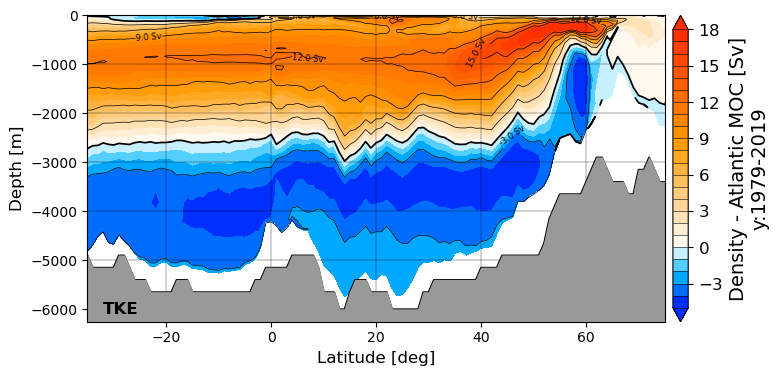

In [12]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = dmoc_list[0][list(dmoc_list[0].keys())[0]].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
ncol   = np.min([ncol,len(dmoc_list)])    
nrow   = np.ceil(len(dmoc_list)/ncol).astype('int')
if save_fname is not None: spath = save_fname

#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_dmoc(mesh, dmoc_list, which_moc=vname, which_transf=which_transf, 
                            cinfo=cinfo, do_reffig=do_reffig, ref_cinfo=ref_cinfo, 
                            figsize=[ncol*figfac[0], nrow*figfac[1]], n_rc=[nrow, ncol], 
                            do_save=spath, save_dpi=which_dpi, do_contour=do_contour, do_yrescale=True, do_zcoord=do_zcoord)